# Real case verification: the Braunsbach event 

In [1]:
# import rainymotion library
from rainymotion import models, metrics, utils

# import accompanying libraries
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt

% matplotlib inline

/home/hydrogo/anaconda3/envs/rainymotion/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = h5py.File("../../../data/data.h5", mode="r")
eval_idx = np.load("../../../data/eval_dict.npy").item()

In [3]:
results = h5py.File("../../../data/results.h5")

In [4]:
def ground_truth(data_instance, eval_instance, results_instance):
    
    results_instance.create_group("/GT/")
    
    for key in sorted(list(eval_instance.keys())):
               
        ground_truth = np.array([ data_instance[key][()] for key in eval_instance[key][1] ])
        
        results_instance["/GT/"].create_dataset(key, 
                                                data=ground_truth, 
                                                dtype="float16", 
                                                chunks=(12,100,100), 
                                                maxshape=(12,900,900), compression="gzip")

In [5]:
%%time
ground_truth(data, eval_idx, results)

CPU times: user 1min 21s, sys: 507 ms, total: 1min 21s
Wall time: 1min 21s


In [6]:
def persistence(data_instance, eval_instance, results_instance):
    
    results_instance.create_group("/Persistence/")
    
    for key in sorted(list(eval_instance.keys())):
        
        inputs = np.array([ data_instance[key][()] for key in eval_instance[key][0][-1:] ])
        
        model = models.EulerianPersistence()
        
        model.input_data = inputs
        
        nowcast = model.run()
        
        results_instance["/Persistence/"].create_dataset(key,
                                                         data=nowcast, 
                                                         dtype="float16",
                                                         chunks=(12,100,100),
                                                         maxshape=(12,900,900), 
                                                         compression="gzip")

In [7]:
%%time
persistence(data, eval_idx, results)

CPU times: user 51.3 s, sys: 840 ms, total: 52.2 s
Wall time: 52.3 s


In [8]:
def optical_flow(data_instance, eval_instance, results_instance, model_name):
    
    if model_name == "Sparse":
        model = models.Sparse()
    
    elif model_name == "SparseSD":
        model = models.SparseSD()
    
    elif model_name == "Dense":
        model = models.Dense()
    
    elif model_name == "DenseRotation":
        model = models.DenseRotation()
    
    results_instance.create_group("/{}/".format(model_name))
    
    for key in sorted(list(eval_instance.keys())):
        
        inputs = np.array([ data_instance[key][()] for key in eval_instance[key][0] ])
        
        inputs, c1, c2 = utils.RYScaler(inputs.astype("float64"))
        
        model.input_data = inputs
        
        nowcast = model.run()
        
        nowcast = utils.inv_RYScaler(nowcast, c1, c2).astype("float16")
        
        results_instance["/{}/".format(model_name)].create_dataset(key, 
                                                                   data=nowcast,
                                                                   dtype="float16",
                                                                   chunks=(12,100,100),
                                                                   maxshape=(12,900,900),
                                                                   compression="gzip")

In [9]:
%%time
optical_flow(data, eval_idx, results, "Sparse")

CPU times: user 7min 35s, sys: 2min 38s, total: 10min 13s
Wall time: 6min 44s


In [10]:
%%time
optical_flow(data, eval_idx, results, "SparseSD")

CPU times: user 6min 46s, sys: 2min 39s, total: 9min 26s
Wall time: 6min 27s


In [11]:
%%time
optical_flow(data, eval_idx, results, "Dense")

CPU times: user 7h 17min 49s, sys: 2h 5min 31s, total: 9h 23min 20s
Wall time: 6h 46min 45s


In [12]:
%%time
optical_flow(data, eval_idx, results, "DenseRotation")

CPU times: user 7h 18min 57s, sys: 2h 4min 31s, total: 9h 23min 28s
Wall time: 6h 48min 9s


In [13]:
def calculate_CSI(obs, sim, thresholds=[0.125, 0.250, 0.500, 1.000]):
    
    result = {}
    
    for threshold in thresholds:
        result[str(threshold)] = [metrics.CSI(obs[i], sim[i], threshold=threshold) for i in range(obs.shape[0])]
    
    return result

def calculate_MAE(obs, sim):
    
    return [metrics.MAE(obs[i], sim[i]) for i in range(obs.shape[0])]

def calculate_metrics_dict(eval_instance, results_instance, 
                           model_names=["Persistence", "Sparse", "SparseSD", "Dense", "DenseRotation"]):
    
    metrics_dict = OrderedDict()
    
    for model_name in model_names:
        
        metrics_dict[model_name] = OrderedDict()
        
        for key in sorted(list(eval_instance.keys())):
            
            metrics_dict[model_name][key] = {model_name: {"CSI": None, "MAE": None}}
            
            # observed ground-truth
            o = results_instance["GT"][key][()]
            
            # results of nowcasting
            s = results_instance[model_name][key][()]
            
            # convert values from depth (mm) to intensity (mm/h)
            o = utils.depth2intensity(o)
            s = utils.depth2intensity(s)
            
            metrics_dict[model_name][key][model_name]["CSI"] = calculate_CSI(o, s)
            metrics_dict[model_name][key][model_name]["MAE"] = calculate_MAE(o, s)
    
    return metrics_dict

In [14]:
%%time
metrics_dict = calculate_metrics_dict(eval_idx, results)

CPU times: user 8min 10s, sys: 7.59 s, total: 8min 18s
Wall time: 8min 18s


In [15]:
np.save("../../../data/results_metrics.npy", metrics_dict)

In [16]:
def MAE_simple_plot(metrics_dict, ax, axis=0):
    
    ### data preparation block ###
    event_name = "Braunsbach"
    # create a useful keys
    model_names = sorted(list(metrics_dict.keys()))
      
    main_keys = sorted(list(metrics_dict[model_names[0]].keys()))
    
    # create a holder for averaged MAE results
    mae = {model_name: None for model_name in model_names}
    
    for model_name in model_names:
        mae[model_name] = np.array( [metrics_dict[model_name][step][model_name]["MAE"] for step in main_keys] )
       
    ###   ###   ###
    t = range(5, 65, 5)
    
    #fig, ax = plt.subplots(figsize=(12, 8))
    
    for model in model_names:
        
        data = mae[model]
        
        data_to_plot = np.mean(data, axis=axis)
        
        ax.plot(t, data_to_plot, label=model)
    
    ax.grid(linestyle="--")
    ax.legend(fontsize=14)
    
    ax.set_title("{}: {} -- {}".format(event_name.title(), main_keys[0], main_keys[-1]), fontsize=16)
    ax.set_xlabel("Lead time, min", fontdict={"size": 16})
    ax.set_ylabel("MAE, mm/h", fontdict={"size": 16})
    
    ax.tick_params(labelsize=14)
    
    return ax

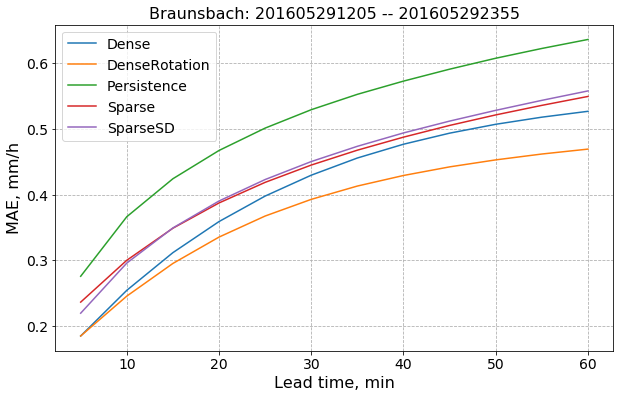

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax = MAE_simple_plot(metrics_dict, ax)

In [18]:
def CSI_simple_plot(metrics_dict, threshold, ax):
    
    """
    threshold should be a string from ['0.125', '0.25', '0.5', '1.0']
    """
    event_name = "Braunsbach"
    # create a useful keys
    model_names = sorted(list(metrics_dict.keys()))
    
    main_keys = sorted(list(metrics_dict[model_names[0]].keys()))
    
    # create a holder for averaged MAE results
    csi = {model_name: None for model_name in model_names}
    
    for model_name in model_names:
        csi[model_name] = np.array( [metrics_dict[model_name][step][model_name]["CSI"][threshold] for step in main_keys] )
    
    ###
    
    t = range(5, 65, 5)
         
    for model in model_names: 

        data = csi[model]
        data_to_plot = np.mean(data, axis=0)
        ax.plot(t, data_to_plot, label=model)

    ax.grid(linestyle="--")
    ax.legend(fontsize=14)
    
    ax.set_title("{}: {} -- {}, CSI threshold: {} mm/h".format(event_name.title(),
                                                               main_keys[0],
                                                               main_keys[-1],
                                                               threshold), 
                 fontsize=16)
    
    ax.set_xlabel("Lead time, min", fontdict={"size": 16})
    ax.set_ylabel("CSI", fontdict={"size": 16})
    
    ax.tick_params(labelsize=14)

    return ax

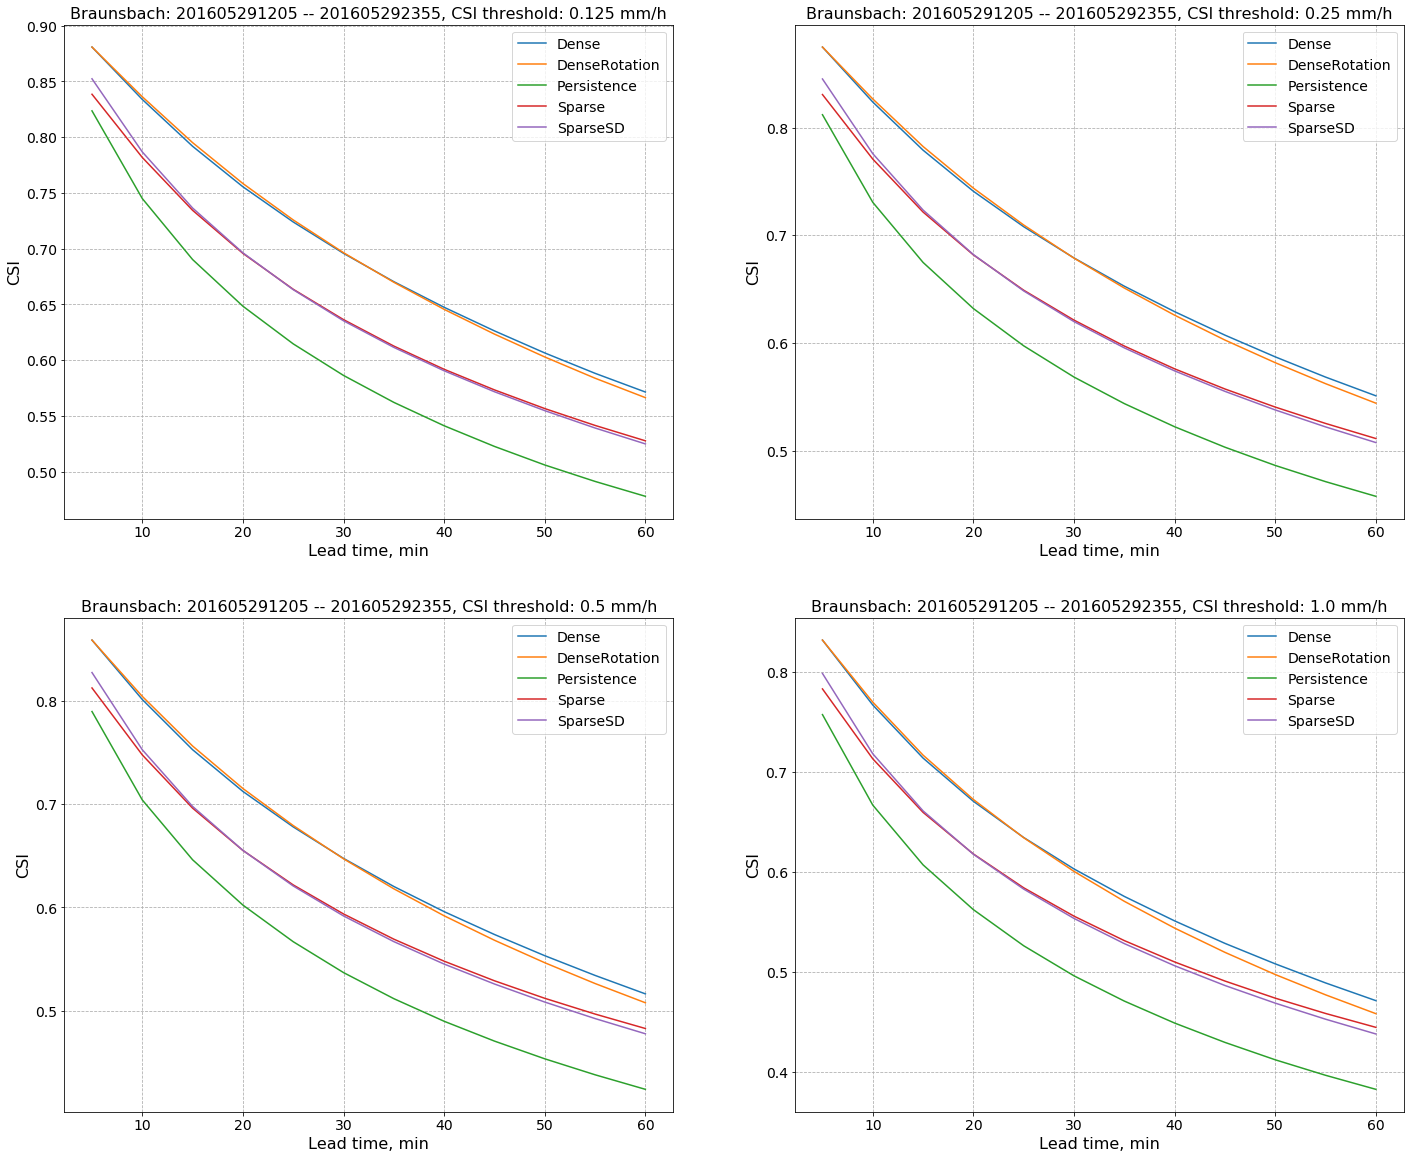

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(24,20))
axes = axes.ravel()
for i, threshold in enumerate(['0.125', '0.25', '0.5', '1.0']):
    axes[i] = CSI_simple_plot(metrics_dict, threshold, axes[i])